## XGBoost models


XGBoost based models are slightly finicky to get into a suitable onnx format. By default most tree based models will export into something that looks like this: 


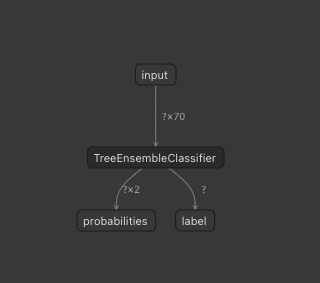


Processing such nodes can be difficult and error prone. It would be much better if the operations of the tree were represented as a proper graph, possibly ... like this: 


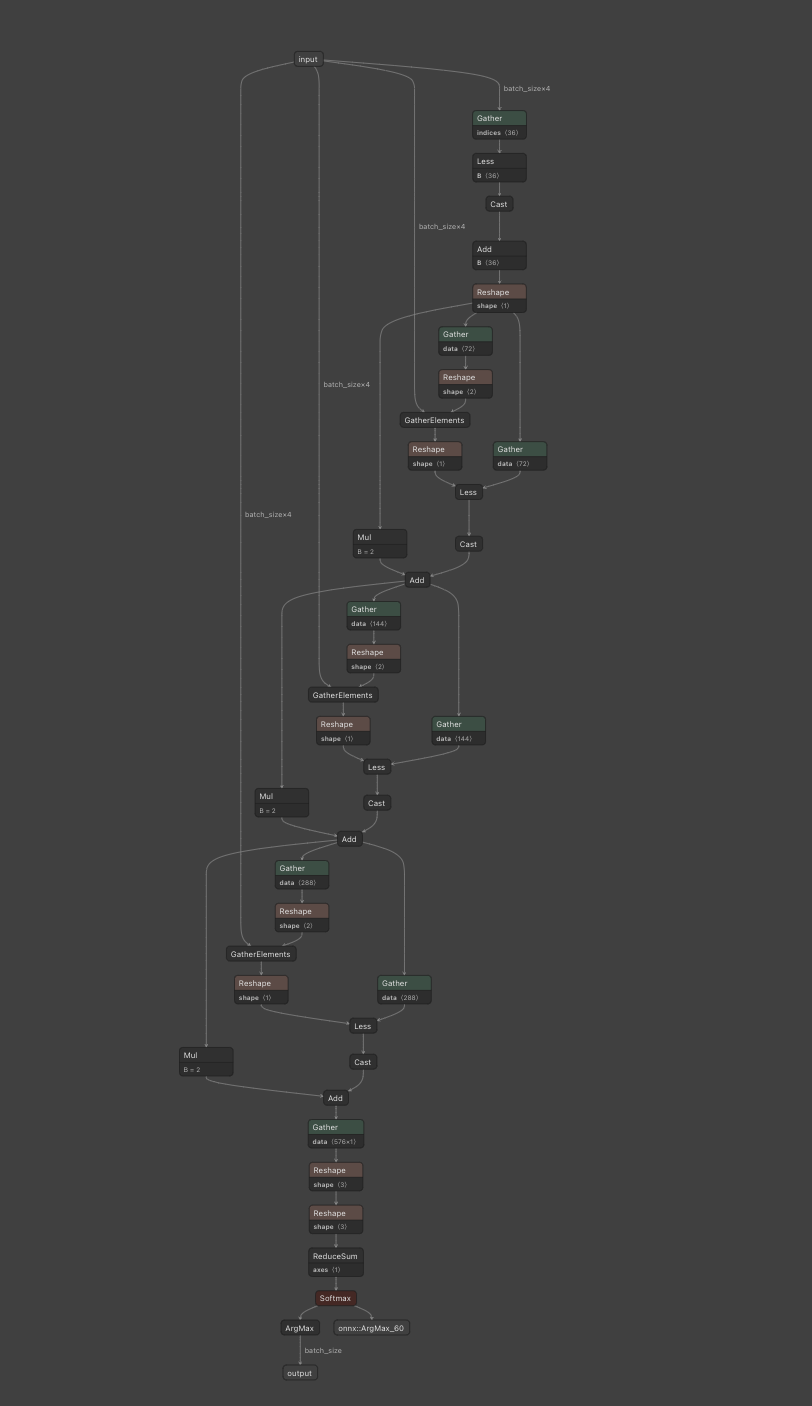


This notebook showcases how to do that using the `hummingbird` python package ! 

In [ ]:
!python -m pip install hummingbird_ml

In [ ]:
# check if notebook is in colab
try:
    # install ezkl
    import google.colab
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "ezkl"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "onnx"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "hummingbird-ml"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "xgboost"])

# rely on local installation of ezkl if the notebook is not in colab
except:
    pass


# here we create and (potentially train a model)

# make sure you have the dependencies required here already installed
import json
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier as Gbc
import torch
import ezkl
import os
from torch import nn
import xgboost as xgb
from hummingbird.ml import convert

NUM_CLASSES = 3

iris = load_iris()
X, y = iris.data, iris.target
X = X.astype(np.float32)
X_train, X_test, y_train, y_test = train_test_split(X, y)
clr = Gbc(n_estimators=12)
clr.fit(X_train, y_train)

# convert to torch


torch_gbt = convert(clr, 'torch')

print(torch_gbt)
# assert predictions from torch are = to sklearn
diffs = []

for i in range(len(X_test)):
    torch_pred = torch_gbt.predict(torch.tensor(X_test[i].reshape(1, -1)))
    sk_pred = clr.predict(X_test[i].reshape(1, -1))
    diffs.append(torch_pred != sk_pred[0])

print("num diff: ", sum(diffs))



In [ ]:
model_path = os.path.join('network.onnx')
compiled_model_path = os.path.join('network.compiled')
pk_path = os.path.join('test.pk')
vk_path = os.path.join('test.vk')
settings_path = os.path.join('settings.json')
srs_path = os.path.join('kzg.srs')
witness_path = os.path.join('witness.json')
data_path = os.path.join('input.json')

In [ ]:
# !!!!!!!!!!!!!!!!! This cell will flash a warning about onnx runtime compat but it is fine !!!!!!!!!!!!!!!!!!!!!


# export to onnx format


# Input to the model
shape = X_train.shape[1:]
x = torch.rand(1, *shape, requires_grad=False)
torch_out = torch_gbt.predict(x)
# Export the model
torch.onnx.export(torch_gbt.model,               # model being run
                  # model input (or a tuple for multiple inputs)
                  x,
                  # where to save the model (can be a file or file-like object)
                  "network.onnx",
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=18,          # the ONNX version to export the model to
                  input_names=['input'],   # the model's input names
                  output_names=['output'],  # the model's output names
                  dynamic_axes={'input': {0: 'batch_size'},    # variable length axes
                                'output': {0: 'batch_size'}})

d = ((x).detach().numpy()).reshape([-1]).tolist()

data = dict(input_shapes=[shape],
            input_data=[d],
            output_data=[(o).reshape([-1]).tolist() for o in torch_out])

# Serialize data into file:
json.dump(data, open("input.json", 'w'))


In [ ]:
run_args = ezkl.PyRunArgs()
run_args.variables = [("batch_size", 1)]

# TODO: Dictionary outputs
res = ezkl.gen_settings(model_path, settings_path, py_run_args=run_args)
assert res == True

res = await ezkl.calibrate_settings(data_path, model_path, settings_path, "resources")
assert res == True

In [ ]:
res = ezkl.compile_circuit(model_path, compiled_model_path, settings_path)
assert res == True

In [ ]:
# srs path
res = ezkl.get_srs(srs_path, settings_path)

In [ ]:
# now generate the witness file 

res = ezkl.gen_witness(data_path, compiled_model_path, witness_path)
assert os.path.isfile(witness_path)

In [ ]:

# HERE WE SETUP THE CIRCUIT PARAMS
# WE GOT KEYS
# WE GOT CIRCUIT PARAMETERS
# EVERYTHING ANYONE HAS EVER NEEDED FOR ZK



res = ezkl.setup(
        compiled_model_path,
        vk_path,
        pk_path,
        srs_path,
    )

assert res == True
assert os.path.isfile(vk_path)
assert os.path.isfile(pk_path)
assert os.path.isfile(settings_path)

In [ ]:
# GENERATE A PROOF


proof_path = os.path.join('test.pf')

res = ezkl.prove(
        witness_path,
        compiled_model_path,
        pk_path,
        proof_path,
        srs_path,
        "single",
    )

print(res)
assert os.path.isfile(proof_path)

In [ ]:
# VERIFY IT

res = ezkl.verify(
        proof_path,
        settings_path,
        vk_path,
        srs_path,
    )

assert res == True
print("verified")

In [ ]:
# VERIFY IT

res = ezkl.verify(
        proof_path,
        settings_path,
        vk_path,
        srs_path,
    )

assert res == True
print("verified")